# Correlation-Based Neighbourhood Model with Implicit Feedback implementation

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from scipy.stats import pearsonr

def number_user(R_i, R_j):
    """ Calculate number of users that rated both movie i and movie j.

    Parameters:
        R_i (1-D np.array): Variable i (i-th movie).
        R_j (1-D np.array): Variable j (j-th movie).

    Returns:
        n_ij (float): Number of users that rated both movie i and movie j.

    """

    n_ij = 0
    for a, b in zip(R_i, R_j):
        if a and b :  # Increment n_ij if both ratings are not equal to zero
            n_ij += 1
            
    return n_ij

In [0]:
def similarity_matrix(R, lambda_2=100):
    """ Calculate the similarity

    Parameters: 
    R (csr_matrix): Ratings matrix.
    lamdba_1 (float): Regulation coefficient. 
  
    Returns: 
    S (array): Similarity matrix

    """

    R = R.tocsr()
    n = R.shape[1]
    S = np.zeros((n, n))
    for i in range(n):
        R_i = R[:, i].toarray()  # i-th variable's data
        v_i = [v[0] for v in R_i]  # We're using lists since we can't  multiply a sequence by a float 
        for j in range(i+1):
            R_j = R[:, j].toarray()  # j-th variable's data
            v_y = [v[0] for v in R_j] 
            
            # Calculate number of users that rated both i and j
            n_ij = number_user(R_i, R_j)

            # Calculate S_ij using the giving formula
            S[i, j], _ = (n_ij / (n_ij + lambda_2))*np.asarray(pearsonr(v_i, v_y))
    S += S.T
    
    return S

In [0]:
def k_explicit_neighbours(R, S, u, i, k):
    """ Calculate set of movies for which ratings by user u are available.

    Parameters: 
    R (csr_matrix): Ratings matrix.
    S (2-D np.array): Similarity matrix.
    u (int): User's index.
    i (int): Movie's index.
    k (int): Number of movie's neighbours to consider.

    Returns: 
    R_iu_k (1-D np.array): Set of k nearest movies for which 
                       ratings by u are available.
    """

    S_i = S[:, i]
    R_ui = {} # Dictionnary: Movie_index -> similarity with movie i if r_ui > 0

    for j in range(len(S_i)):
        if R[u, j] > 0:  # Add movie and it's similarity to i if u has given a rating
            R_ui[j] = S_i[j]

    # Remove i if it's one of the selected neighboors
    if i in R_ui:
        del R_ui[i]
    
    # Sort by similarity and keep the first k indices
    R_iu_k = [v[0] for v in 
             sorted(R_ui.items(), key=lambda x: x[1], reverse=True)[:k]]

    return R_iu_k

In [0]:
def k_implicit_neighbours_movies(R, S, u, i, k):
    """ Calculate set of movies for which user u provided an implicit preference.

    Note:
        Apparently, for the netflix data implicit set is equal to 
        the explicit set.

    Parameters: 
    R (csr_matrix): Ratings matrix.
    S (2-D np.array): Similarity matrix.
    u (int): User's index.
    i (int): Movie's index.
    k (int): Number of movie's neighbours to consider.

    Returns: 
    N_iu_k (1-D np.array): Set of k nearest movies for which 
                       ratings by u are available.
    """
    
    N_iu_k = k_explicit_neighbours(R, S, u, i, k)
    
    return N_iu_k

In [0]:
def gradient_J(R, S, k, B_i, B_u, mu, W, C, lambda_4):
    """Calculate stochastic gradient descent for the correlation
    Based Implicit Neighbourhood model.

    Parameters:
        R (coo_matrix): Rating matrix.
        S (2-D np.array): Similarity matrix.
        k (int): Number of movie's neighbours to consider.
        B_i (1-D np.array): Observed deviation for each movie.
        B_i (1-D np.array): Observed deviation for each user.
        W (2-D np.array): Parameter associated to the similarity 
                          between movies i and j.
        C (2-D np.array): Parameter associated to the categories 
                          of movies i and j.
        mu (float): Overall average rating.
        lambda_4 (float): Penality coefficient.

    Returns:
        b_i (1-D np.array): Gradient of observed deviation for each movie.
        b_u (1-D np.array): Gradient of observed deviation for each user.
        w (2-D np.array): Gradient of the parameter associated to the 
                          similarity between movies i and j.
        c (2-D np.array): Gradient of the parameter associated to the 
                          categories of movies i and j.

    """

    users, items = R.nonzero()
    b_u, b_i =  np.zeros(len(B_u)), np.zeros(len(B_i))
    w = np.zeros((len(W), len(W)))
    c = np.zeros((len(C), len(C)))

    for u, i in zip(users, items):
        R_iu_k = k_explicit_neighbours(R, S, u, i, k)
        # N_i_u_k = k_implicit_neighbours_movies(R, S, u, i, k)
        N_iu_k = R_iu_k
        r_iu_k = sum((R[u, j] - B_u[u] - B_i[j] - mu)*W[i, j] 
                for j in R_iu_k)
        n_iu_k = sum([C[i, j] for j in N_iu_k])
        r_ui = mu + B_u[u] + B_i[i] + (r_iu_k / np.sqrt(len(R_iu_k))) + (
            n_iu_k / np.sqrt(len(N_iu_k)))
        
        e = R[u, i] - r_ui

        b_u[u] += e - lambda_4*B_u[u]
        b_i[i] += e - lambda_4*B_i[i]

        # For each movie in R_iu_k, update w
        for j in R_iu_k:
            w[i, j] += (R[u, j] - B_u[u] - B_i[j] - mu)*e/np.sqrt(len(R_iu_k)) - \
                        lambda_4*W[i, j]
                        
        # For each movie in R_iu_k, update c
        for j in N_iu_k:
            c[i, j] += e/np.sqrt(len(N_iu_k)) - lambda_4*C[i, j]
        
    return -2*b_i, -2*b_u, -2*w, -2*c

In [0]:
def rmse(R, S, k, B_i, B_u, mu, W, C):
    """Calculate the root-mean-square deviation using the
       estimated parameters.

    Parameters:
        R (coo_matrix): Rating matrix.
        S (2-D np.array): Similarity matrix.
        k (int): Number of movie's neighbours to consider.
        B_i (1-D np.array): Observed deviation for each movie.
        B_i (1-D np.array): Observed deviation for each user.
        W (2-D np.array): Parameter associated to the similarity 
                          between movies i and j.
        C (2-D np.array): Parameter associated to the categories 
                          of movies i and j.
        mu (float): Overall average rating.

    Returns:
        error (float): RMSE error value.

    """

    users, items = R.nonzero()
    error = 0
    for u, i in zip(users, items):
        R_iu_k = k_explicit_neighbours(R, S, u, i, k)
        N_iu_k = R_iu_k

        r_iu_k = sum((R[u, j] - B_u[u] - B_i[j] - mu)*W[i, j] 
                        for j in R_iu_k)
        n_iu_k = sum([C[i, j] for j in N_iu_k])
        
        r = mu + B_u[u] + B_i[i] + (r_iu_k / np.sqrt(len(R_iu_k))) + (n_iu_k / np.sqrt(len(N_iu_k)))
        error += pow(R[u, i] - r, 2)
    error = (1 / R.shape[0]) * error

    return error

In [0]:
def recreate_matrix(R, B_i, B_u, mu, W, C, S, k):
    """Recreate the matrix using estimated parameters.

    Parameters:
        R (coo_matrix): Rating matrix.
        S (2-D np.array): Similarity matrix.
        k (int): Number of movie's neighbours to consider.
        B_i (1-D np.array): Observed deviation for each movie.
        B_i (1-D np.array): Observed deviation for each user.
        W (2-D np.array): Parameter associated to the similarity 
                          between movies i and j.
        C (2-D np.array): Parameter associated to the categories 
                          of movies i and j.
        mu (float): Overall average rating.

    Returns:
        R_estimated (2-D np.array): Recreated rating matrix.

    """

    R = R.tocsr()
    R_estimated = np.zeros((len(B_u), len(B_i)))

    for u in range(len(B_u)):
        for i in range(len(B_i)):
            R_iu_k = k_explicit_neighbours(R, S, u, i, k)
            N_iu_k = R_iu_k

            r_iu_k = sum((R[u, j] - B_u[u] - B_i[j] - mu)*W[i, j] 
                            for j in R_iu_k)
            n_iu_k = sum([C[i, j] for j in N_iu_k])
            
            R_estimated[u, i] = mu + B_u[u] + B_i[i] + (r_iu_k / np.sqrt(
                                len(R_iu_k))) + (n_iu_k / np.sqrt(len(N_iu_k)))

    return R_estimated

In [0]:
def recommend_k_movies(R, B_i, B_u, mu, W, C, S, k, u, k_m):
    """Recommend k movies to the user u.

    Parameters:
        R (coo_matrix): Rating matrix.
        S (2-D np.array): Similarity matrix.
        k (int): Number of movie's neighbours to consider.
        B_i (1-D np.array): Observed deviation for each movie.
        B_i (1-D np.array): Observed deviation for each user.
        W (2-D np.array): Parameter associated to the similarity 
                          between movies i and j.
        C (2-D np.array): Parameter associated to the categories 
                          of movies i and j.
        mu (float): Overall average rating.
        u (int): Index of the user.
        k_m (int): Number of movie to recommend.

    Returns:
        R_u_k (list): List of recommended movies' indices.

    """
    
    R = R.tocsr()
    R_u = {}
    for i in range(len(B_i)):
        if R[u, i] == 0:  # If the user u didn't watch the movie i yet
            R_iu_k = k_explicit_neighbours(R, S, u, i, k)
            N_iu_k = R_iu_k

            r_iu_k = sum((R[u, j] - B_u[u] - B_i[j] - mu)*W[i, j] 
                            for j in R_iu_k)
            n_iu_k = sum([C[i, j] for j in N_iu_k])
            
            R_u[i] = mu + B_u[u] + B_i[i] + (r_iu_k / np.sqrt(
                                len(R_iu_k))) + (n_iu_k / np.sqrt(len(N_iu_k)))
    
    # Sort movies by estimated rating and keep the first k movies
    R_u_k_m = [v[0] for v in 
             sorted(R_u.items(), key=lambda x: x[1], reverse=True)[:k_m]]
    
    return R_u_k_m

In [0]:
def correlation_based_implicit_neighbourhood_model(
    R, N, k, delta=0.01, lambda_2=0.02, lambda_4=0.02, verbose=False, plot=True):
    """Estimate Correlation based implicit neighbourhood model 
       parameters using SGD.

    Parameters:
        R (coo_matrix): Rating matrix.
        N (int): Number of iterations.
        k (int): Number of movie's neighbours to consider.
        delta (float): Learning rate.
        lambda_4 (float): Penality coefficient.
        plot (boolean): Plot RMSE track if True.
        verbose (boolean): Print number of the current iteration at excecution.

    Returns:
        B_i_opt (1-D np.array): Optimal observed deviation for each movie.
        B_u_opt (1-D np.array): Optimal observed deviation for each user.
        W_opt (2-D np.array): Optimal value of the parameter associated 
                              to the similarity between movies i and j.
        C_opt (2-D np.array): Optimal Pvalue of the parameter associated
                              to the categories of movies i and j.
        S (2-D np.array): Similarity matrix.

    """

    # Weight initialization
    B_u = 2.5 * np.random.rand(R.shape[0])
    B_i = 2.5 * np.random.rand(R.shape[1])
    W = 2.5 * np.random.rand(R.shape[1], R.shape[1])
    C = 2.5 * np.random.rand(R.shape[1], R.shape[1])

    # Logs initialization
    mse_track = np.zeros(N) 
    w_track = []

    # Calculate overall average rating value
    mu = R.data.mean()

    # Convert R into a csr_matrix
    R = R.tocsr()

    # Calculate similarity matrix
    S = similarity_matrix(R, lambda_2=lambda_2)

    # SDG on N iterations
    for i in range(N):
        if verbose:
            print("Iteration "+ str(i))
        
        # Calculate SGD 
        gradient = gradient_J(R, S, k, B_i, B_u, mu, W, C, lambda_4)
        B_i = B_i - delta * gradient[0] 
        B_u = B_u - delta * gradient[1]
        W = W - delta * gradient[2]
        C = C - delta * gradient[3]

        # Saving RMSE values
        mse_track[i] = rmse(R, S, k, B_i, B_u, mu, W, C)

        # Saving estimated parameters
        w_track.append([B_i, B_u, W, C])

        #if i>0 and pow(mse_track[i] - mse_track[i-1], 2) < pow(10, -6): break

    # Selecting the optimal parameters
    idx_min = np.argmin(mse_track)
    B_i_opt = w_track[idx_min][0]
    B_u_opt = w_track[idx_min][1]
    W_u_opt = w_track[idx_min][2]
    C_u_opt = w_track[idx_min][3]

    # Ploting RMSE deviation if plot is True
    if plot:
        mse_track = np.array([float(round(mse,3)) for mse in mse_track])
        plt.figure(figsize = (20,8))
        plt.rcParams['axes.facecolor'] = 'orange'
        plt.grid(c='white')
        plt.plot(np.arange(0,N), mse_track, 'blue')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.title('Minimum MSE = {:.4f} reached at iteration {}'.format(min(mse_track),idx_min+1), fontsize = 15)
        plt.axvline(x = idx_min, color = 'green')

    return B_i_opt, B_u_opt, W_u_opt, C_u_opt, S

# Dump example

In [19]:
from scipy.sparse import coo_matrix
R = coo_matrix(np.array([
                [0, 3, 0, 4, 0, 5, 2],
                [1, 0, 0, 2, 1, 2, 0],
                [5, 2, 4, 5, 0, 0, 3],
                [3, 0, 0, 3, 5, 5, 1],
                [1, 0, 5, 0, 1, 1, 0],
                [2, 4, 1, 4, 2, 3, 0],
                [0, 0, 0, 2, 0, 0, 4],
                [1, 4, 4, 3, 3, 0, 2]]
))

# Calculating the Similarity matrice
S = similarity_matrix(R)
S

array([[ 0.11320755,  0.00116995,  0.01229715,  0.02502684,  0.01024774,
        -0.0030502 ,  0.00081666],
       [ 0.00116995,  0.07692308,  0.00540691,  0.02419159,  0.00042778,
         0.00070939,  0.00074511],
       [ 0.01229715,  0.00540691,  0.07692308, -0.00520629, -0.00214576,
        -0.0119774 , -0.00084693],
       [ 0.02502684,  0.02419159, -0.00520629,  0.13084112, -0.00099808,
         0.00827561,  0.01593902],
       [ 0.01024774,  0.00042778, -0.00214576, -0.00099808,  0.0952381 ,
         0.01449574, -0.00731571],
       [-0.0030502 ,  0.00070939, -0.0119774 ,  0.00827561,  0.01449574,
         0.0952381 , -0.00779897],
       [ 0.00081666,  0.00074511, -0.00084693,  0.01593902, -0.00731571,
        -0.00779897,  0.0952381 ]])

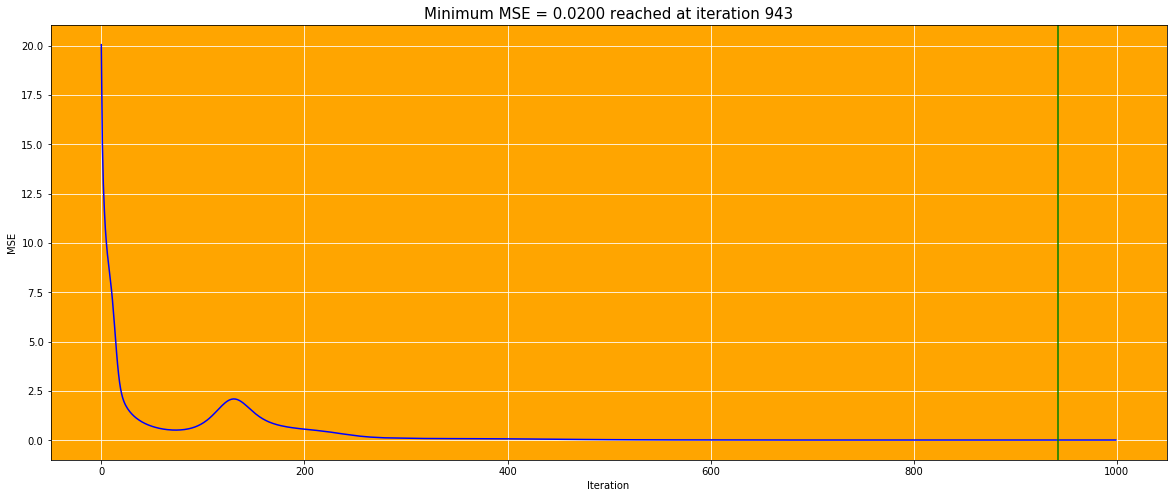

In [20]:
# Estimate Correlation based implicit neighbourhood model parameters using SGD.

B_i_opt, B_u_opt, W_u_opt, C_u_opt, S = correlation_based_implicit_neighbourhood_model(R, N=1000, k=3, delta=0.01, lambda_4=0.02, plot=True)

In [25]:
recreate_matrix(R, B_i_opt, B_u_opt, R.data.mean(), W_u_opt, C_u_opt, S, k=3)

array([[ 4.51183784,  3.00411407,  5.30232647,  3.93990509,  4.23125093,
         4.94750807,  2.05635538],
       [ 0.95654788,  1.43428033,  1.81069343,  2.01565952,  1.13665476,
         2.00432422, -0.79567048],
       [ 4.95508167,  2.06351512,  3.99164463,  4.93540886,  3.40197985,
         5.93404803,  2.98316333],
       [ 2.98060056,  2.95258424,  3.93062373,  3.11785469,  4.84101675,
         4.96084017,  1.05293507],
       [ 0.99790772,  5.73768731,  4.97934938,  2.25818622,  1.02486949,
         1.01677619,  2.63121919],
       [ 2.02472336,  3.95123891,  1.113231  ,  3.88920406,  2.03335151,
         3.02382207,  1.68780139],
       [ 3.16768476,  4.5398436 ,  2.93703341,  2.08764898,  6.90010932,
         6.90022973,  3.91652057],
       [ 1.12982647,  3.96811918,  3.91878359,  3.00845275,  2.96757612,
         3.92768675,  2.00886024]])

In [32]:
# Recommend k movies to user u uing the Model.

recommend_k_movies(R, B_i_opt, B_u_opt, R.data.mean(), W_u_opt, C_u_opt, S, k=3, u = 4, k_m = 3)

[1, 6, 3]

In [0]:
R.toarray()

array([[0, 3, 0, 4, 0, 5, 2],
       [1, 0, 0, 2, 1, 2, 0],
       [5, 2, 4, 5, 0, 0, 3],
       [3, 0, 0, 3, 5, 5, 1],
       [1, 0, 5, 0, 1, 1, 0],
       [2, 4, 1, 4, 2, 3, 0],
       [0, 0, 0, 2, 0, 0, 4],
       [1, 4, 4, 3, 3, 0, 2]], dtype=int64)

# Real application

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***L'execution de cette partie prend beaucoup de temps sur Colab !***

In [0]:
from scipy.sparse import save_npz, load_npz, coo_matrix

def load_matrix(M_name):
    """ Load previously saved sparce matrix M.

    Parameters:
        M_name (string): Matrix name as saved in drive (R, T or D).

    Returns:
        M (coo_matrix): Saved matrix.

    """

    M = load_npz("/content/drive/My Drive/Factorisation matricielle - dataset/training_set_csv/"+M_name+".npz")

    return M

In [0]:
# Loading R matrix

R = load_matrix("R")

In [0]:
import datetime
start = datetime.datetime.now()

B_i_opt, B_u_opt, W_u_opt, C_u_opt, S = correlation_based_implicit_neighbourhood_model(T, N=500, k=5, delta=0.01, lambda_4=0.02, plot=True)

print("Parameters estimated in : {}".format(datetime.datetime.now() - start))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [0]:
import datetime
start = datetime.datetime.now()

R_estimate = recreate_matrix(B_i_opt, B_u_opt, R.data.mean(), W_u_opt, C_u_opt, S, k=3)

print("Parameters estimated in : {}".format(datetime.datetime.now() - start))